In [1]:




!pip install -q timm einops pytorch-msssim torchmetrics
!pip install -q albumentations opencv-python-headless
!pip install -q scikit-image tifffile

import os
if not os.path.exists('SwinIR'):
    !git clone https://github.com/JingyunLiang/SwinIR.git
    
print("✅ Installation complete!")

Cloning into 'SwinIR'...
remote: Enumerating objects: 333, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 333 (delta 6), reused 2 (delta 2), pack-reused 323 (from 2)
Receiving objects: 100% (333/333), 29.84 MiB | 41.51 MiB/s, done.
Resolving deltas: 100% (119/119), done.
✅ Installation complete!


In [2]:
# ============================================================================
# CELL 2: IMPORTS
# ============================================================================

import sys
sys.path.append('SwinIR')

import os
import gc
import numpy as np
import pandas as pd
import cv2
import math
import tifffile as tiff
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from torch.utils.checkpoint import checkpoint

from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
from typing import Tuple, List, Optional, Dict, Any

from models.network_swinir import SwinIR

torch.manual_seed(42)
np.random.seed(42)

# Enable memory efficient settings
torch.backends.cudnn.benchmark = True
torch.backends.cuda.matmul.allow_tf32 = True

print("✅ Imports complete!")

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

✅ Imports complete!


/usr/local/lib/python3.12/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


In [3]:
# ============================================================================
# CELL 3: DATASET PATH
# ============================================================================

DATASET_PATH = '/kaggle/input/worldstrat'
print("Dataset files:", os.listdir(DATASET_PATH))

hr_path = f"{DATASET_PATH}/hr_dataset/12bit"
lr_path = f"{DATASET_PATH}/lr_dataset"

print(f"HR areas: {len(os.listdir(hr_path))}")
print(f"LR areas: {len(os.listdir(lr_path))}")

Dataset files: ['hr_dataset', 'metadata.csv', 'lr_dataset']
HR areas: 3929
LR areas: 3928


In [30]:
# ============================================================================
# CELL 4: DATASET CLASS (UNCHANGED)
# ============================================================================

class WorldStratDataset(Dataset):
    def __init__(
        self,
        main_path: str,
        area_names: List[str],
        input_size: int = 160,
        output_size: int = 640,
        transform: Optional[A.Compose] = None,
        num_temporal_frames: int = 8,
        channels: int = 3,
        dtype: str = 'float16'
    ):
        self.main_path = main_path
        self.area_names = area_names
        self.input_size = input_size
        self.output_size = output_size
        self.transform = transform
        self.num_temporal_frames = num_temporal_frames
        self.channels = channels
        self.dtype = getattr(np, dtype)
        self.hr_dataset = f"{main_path}/hr_dataset/12bit"
        self.lr_dataset = f"{main_path}/lr_dataset"

    def __len__(self) -> int:
        return len(self.area_names)

    def get_lr_image(self, area_name: str, subnum: int) -> np.ndarray:
        target_input_area = f"{self.lr_dataset}/{area_name}/L2A"
        rgb_input_path = f"{target_input_area}/{area_name}-{subnum}-L2A_data.tiff"
        try:
            rgb_input_img = tiff.imread(rgb_input_path)[:, :, 4:1:-1]
            resized_img = cv2.resize(rgb_input_img, (self.input_size, self.input_size))
            return resized_img.astype(self.dtype)
        except:
            return np.zeros((self.input_size, self.input_size, self.channels), dtype=self.dtype)

    def get_hr_image(self, area_name: str) -> np.ndarray:
        target_output_area = f"{self.hr_dataset}/{area_name}"
        rgb_output_path = f"{target_output_area}/{area_name}_rgb.png"
        try:
            rgb_output_img = cv2.imread(rgb_output_path, cv2.IMREAD_UNCHANGED)
            rgb_output_img = cv2.cvtColor(rgb_output_img, cv2.COLOR_BGR2RGB)
            resized_img = cv2.resize(rgb_output_img, (self.output_size, self.output_size))
            normalized_img = resized_img / 255.0
            return normalized_img.astype(self.dtype)
        except:
            return np.zeros((self.output_size, self.output_size, self.channels), dtype=self.dtype)

    def _extract_vision_features(self, ref_img):
        gray = (ref_img * 255).astype(np.uint8)
        gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        edges = (edges / 255.0).astype(self.dtype)[..., None]
        lbp = local_binary_pattern(gray, P=8, R=1, method='uniform')
        lbp = (lbp / 9).astype(self.dtype)[..., None]
        sx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=3)
        sy = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=3)
        grad = np.sqrt(sx**2 + sy**2)
        grad = (grad / grad.max()).astype(self.dtype)[..., None]
        return np.concatenate([edges, lbp, grad], axis=2)

    def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
        area_name = self.area_names[idx]
        lr_frames = [self.get_lr_image(area_name, i) for i in range(1, self.num_temporal_frames + 1)]
        lr_temporal_stack = np.concatenate(lr_frames, axis=2)
        vision_feats = self._extract_vision_features(lr_frames[0])
        enhanced_input = np.concatenate([lr_temporal_stack, vision_feats], axis=2)
        hr_target = self.get_hr_image(area_name)
    
        if self.transform:
            enhanced_input = enhanced_input.astype(np.float32)
            transformed = self.transform(image=enhanced_input)
            enhanced_input = transformed['image'].astype(self.dtype)
    
        lr_tensor = torch.from_numpy(enhanced_input).permute(2, 0, 1).float()
        hr_tensor = torch.from_numpy(hr_target).permute(2, 0, 1).float()
    
        return {'input': lr_tensor, 'target': hr_tensor, 'area_name': area_name}

print("✅ Dataset class defined!")

✅ Dataset class defined!


In [5]:
# ============================================================================
# CELL 5: DATA PIPELINE MANAGER
# ============================================================================

class DataPipelineManager:
    def __init__(self, main_path: str, input_size: int = 160, output_size: int = 640,
                 batch_size: int = 1, num_workers: int = 2, val_split: float = 0.2,
                 test_split: float = 0.1, random_seed: int = 42):
        self.main_path = main_path
        self.input_size = input_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.num_workers = num_workers
        self.val_split = val_split
        self.test_split = test_split
        self.random_seed = random_seed
        torch.manual_seed(random_seed)
        np.random.seed(random_seed)
        self.area_names = None
        self.datasets = {}
        self.dataloaders = {}

    def load_area_names(self, limit: Optional[int] = None) -> List[str]:
        hr_dataset_path = f"{self.main_path}/hr_dataset/12bit"
        area_names = os.listdir(hr_dataset_path)
        if limit:
            area_names = area_names[:limit]
        self.area_names = area_names
        print(f"Loaded {len(area_names)} areas")
        return area_names

    def create_transforms(self):
        train_transform = A.Compose([
            A.RandomRotate90(p=0.5),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.2),
            A.GaussNoise(p=0.1),
        ])
        val_transform = A.Compose([])
        return {'train': train_transform, 'val': val_transform, 'test': val_transform}

    def split_dataset(self) -> Dict[str, List[str]]:
        train_val_names, test_names = train_test_split(
            self.area_names, test_size=self.test_split, random_state=self.random_seed
        )
        train_names, val_names = train_test_split(
            train_val_names, test_size=self.val_split / (1 - self.test_split),
            random_state=self.random_seed
        )
        print(f"Train: {len(train_names)} | Val: {len(val_names)} | Test: {len(test_names)}")
        return {'train': train_names, 'val': val_names, 'test': test_names}

    def create_datasets(self, limit_samples: Optional[int] = None):
        self.load_area_names(limit=limit_samples)
        split_data = self.split_dataset()
        transforms = self.create_transforms()
        datasets = {}
        for split in ['train', 'val', 'test']:
            datasets[split] = WorldStratDataset(
                main_path=self.main_path, area_names=split_data[split],
                input_size=self.input_size, output_size=self.output_size,
                transform=transforms[split]
            )
        self.datasets = datasets
        return datasets

    def create_dataloaders(self):
        dataloaders = {}
        for split, dataset in self.datasets.items():
            dataloaders[split] = DataLoader(
                dataset, batch_size=self.batch_size, shuffle=(split == 'train'),
                num_workers=self.num_workers, pin_memory=True, drop_last=(split == 'train')
            )
        self.dataloaders = dataloaders
        return dataloaders

print("✅ DataPipelineManager defined!")

✅ DataPipelineManager defined!


In [6]:
# ============================================================================
# CELL 6: CREATE DATA PIPELINE (BATCH SIZE = 1)
# ============================================================================

pipeline = DataPipelineManager(
    main_path=DATASET_PATH,
    input_size=160,
    output_size=640,
    batch_size=1,  # CRITICAL: batch_size=1 to save memory
    num_workers=2,
    val_split=0.2,
    test_split=0.1,
    random_seed=42
)

datasets = pipeline.create_datasets(limit_samples=50)
dataloaders = pipeline.create_dataloaders()
print("\n✅ Data pipeline ready!")

Loaded 50 areas
Train: 35 | Val: 10 | Test: 5

✅ Data pipeline ready!


In [7]:
# ============================================================================
# CELL 7: MEMORY-OPTIMIZED MODEL
# ============================================================================

class TemporalFusionModule(nn.Module):
    def __init__(self, in_channels=27, out_channels=3):
        super().__init__()
        # Lightweight fusion
        self.fusion = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 24, 3, 1, 1),
            nn.ReLU(inplace=True),
            nn.Conv2d(24, out_channels, 3, 1, 1)
        )
    
    def forward(self, x):
        return self.fusion(x)


from torch.utils.checkpoint import checkpoint

class MemoryEfficientSwinIR(nn.Module):
    def __init__(self, in_channels=27, pretrained_path=None, use_checkpointing=True):
        super().__init__()
        self.use_checkpointing = use_checkpointing
        
        self.temporal_fusion = TemporalFusionModule(in_channels=in_channels, out_channels=3)
        
        self.swinir = SwinIR(
            upscale=4,
            in_chans=3,
            img_size=48,
            window_size=8,
            img_range=1.0,
            depths=[6, 6, 6, 6],
            embed_dim=120,
            num_heads=[6, 6, 6, 6],
            mlp_ratio=2,
            upsampler='pixelshuffle',
            resi_connection='1conv'
        )
        
        if pretrained_path and os.path.exists(pretrained_path):
            print(f"Loading pretrained from {pretrained_path}")
            ckpt = torch.load(pretrained_path, map_location='cpu')
            if 'params' in ckpt:
                self.swinir.load_state_dict(ckpt['params'], strict=False)
            print("✅ Pretrained loaded (partial)")
    
    def forward(self, x):
        x_fused = self.temporal_fusion(x)
        
        _, _, h, w = x_fused.shape
        pad_h = (8 - h % 8) % 8
        pad_w = (8 - w % 8) % 8
        if pad_h > 0 or pad_w > 0:
            x_fused = F.pad(x_fused, (0, pad_w, 0, pad_h), mode='reflect')
        
        if self.use_checkpointing and self.training:
            sr = checkpoint(self.swinir, x_fused, use_reentrant=False)
        else:
            sr = self.swinir(x_fused)
        
        return sr


In [8]:
# ============================================================================
# CELL 8: DOWNLOAD PRETRAINED (OPTIONAL)
# ============================================================================

pretrained_url = "https://github.com/JingyunLiang/SwinIR/releases/download/v0.0/003_realSR_BSRGAN_DFO_s64w8_SwinIR-M_x4_GAN.pth"
pretrained_path = "swinir_pretrained.pth"

if not os.path.exists(pretrained_path):
    print("Downloading pretrained weights...")
    !wget -q {pretrained_url} -O {pretrained_path}
    print("✅ Downloaded!")
else:
    print("✅ Already exists")

✅ Downloaded!


In [9]:
# ============================================================================
# CELL 9: INITIALIZE MODEL
# ============================================================================

# Clear memory first
torch.cuda.empty_cache()
gc.collect()

model = MemoryEfficientSwinIR(
    in_channels=27,
    pretrained_path=pretrained_path if os.path.exists(pretrained_path) else None,
    use_checkpointing=True  # Enable gradient checkpointing
).cuda()

# Test
with torch.no_grad():
    sample = next(iter(dataloaders['train']))
    x = sample['input'].cuda()
    y = model(x)
    print(f"✅ Test: {x.shape} -> {y.shape}")
    del x, y
    torch.cuda.empty_cache()

params = sum(p.numel() for p in model.parameters()) / 1e6
print(f"Model parameters: {params:.2f}M")

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Loading pretrained from swinir_pretrained.pth
✅ Pretrained loaded (partial)
✅ Test: torch.Size([1, 27, 160, 160]) -> torch.Size([1, 3, 640, 640])
Model parameters: 3.87M


In [10]:
from pytorch_msssim import MS_SSIM
import torch
import torch.nn as nn


In [11]:
def range_loss(sr, hr):
    # per-image max (robust, batch-safe)
    sr_max = sr.amax(dim=(1,2,3))
    hr_max = hr.amax(dim=(1,2,3))
    return torch.mean(torch.abs(sr_max - hr_max))


In [12]:
import torch
import torch.nn as nn
import torchvision.models as models

class VGGFeatureExtractor(nn.Module):
    def __init__(self, layer='relu3_3'):
        super().__init__()
        vgg = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features
        
        layer_map = {
            'relu1_2': 4,
            'relu2_2': 9,
            'relu3_3': 14,
            'relu4_3': 23
        }
        
        self.features = nn.Sequential(*vgg[:layer_map[layer]])
        
        for p in self.features.parameters():
            p.requires_grad = False

    def forward(self, x):
        return self.features(x)


In [13]:
def normalize_vgg(x):
    mean = torch.tensor([0.485, 0.456, 0.406], device=x.device).view(1,3,1,1)
    std = torch.tensor([0.229, 0.224, 0.225], device=x.device).view(1,3,1,1)
    return (x - mean) / std


In [14]:
import torch.nn.functional as F

def gradient_loss(sr, hr):
    sobel_x = torch.tensor(
        [[-1, 0, 1],
         [-2, 0, 2],
         [-1, 0, 1]],
        device=sr.device, dtype=sr.dtype
    ).view(1, 1, 3, 3)

    sobel_y = sobel_x.transpose(2, 3)

    sobel_x = sobel_x.repeat(3, 1, 1, 1)
    sobel_y = sobel_y.repeat(3, 1, 1, 1)

    grad_sr_x = F.conv2d(sr, sobel_x, padding=1, groups=3)
    grad_hr_x = F.conv2d(hr, sobel_x, padding=1, groups=3)

    grad_sr_y = F.conv2d(sr, sobel_y, padding=1, groups=3)
    grad_hr_y = F.conv2d(hr, sobel_y, padding=1, groups=3)

    return (
        F.l1_loss(grad_sr_x, grad_hr_x) +
        F.l1_loss(grad_sr_y, grad_hr_y)
    )


In [15]:
# ============================================================================
# CELL 10: LIGHTWEIGHT LOSS
# ============================================================================

from pytorch_msssim import MS_SSIM
import torch
import torch.nn as nn

from pytorch_msssim import MS_SSIM
import torch.nn.functional as F

class PerceptualLoss(nn.Module):
    def __init__(
        self,
        l1_weight=1.0,
        ssim_weight=0.05,
        grad_weight=0.1,
        perc_weight=0.02,
        range_weight = 0.05

    ):
        super().__init__()
        self.l1_loss = nn.L1Loss()
        self.ms_ssim = MS_SSIM(data_range=1.0, size_average=True, channel=3)
        self.vgg = VGGFeatureExtractor(layer='relu3_3')

        self.l1_weight = l1_weight
        self.ssim_weight = ssim_weight
        self.grad_weight = grad_weight
        self.perc_weight = perc_weight
        self.range_weight = range_weight

    def forward(self, sr, hr):
        l1 = self.l1_loss(sr, hr)
    
        ms_ssim_val = self.ms_ssim(sr, hr)
        ssim_loss = 1.0 - ms_ssim_val
        
        r_loss = range_loss(sr, hr)

        grad = gradient_loss(sr, hr)

     
        device = sr.device
        self.vgg = self.vgg.to(device)

        with torch.amp.autocast('cuda', enabled=False):
            sr_vgg = self.vgg(normalize_vgg(sr).float())
            hr_vgg = self.vgg(normalize_vgg(hr).float())
            perc = F.l1_loss(sr_vgg, hr_vgg)

    
       
    
        total = (
            self.l1_weight * l1 +
            self.ssim_weight * ssim_loss +
            self.grad_weight * grad +
            self.perc_weight * perc +
             self.range_weight * r_loss
        )
    
        return total, {
            'l1': l1.item(),
            'ssim_metric': ms_ssim_val.item(),
            'grad': grad.item(),
            'perc': perc.item(),
            'range': r_loss.item(),
            'total': total.item()
        }


criterion = PerceptualLoss(
    l1_weight=1.0,
    ssim_weight=0.15,
    grad_weight=0.1,
    perc_weight=0.05,
    range_weight = 0.05

)



print("✅ Lightweight loss initialized!")

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 548M/548M [00:02<00:00, 224MB/s] 


✅ Lightweight loss initialized!


In [16]:
# ============================================================================
# CELL 11: OPTIMIZER
# ============================================================================

optimizer = optim.AdamW(
    model.parameters(),
    lr=2e-4,
    betas=(0.9, 0.999),
    weight_decay=1e-4
)

num_epochs = 50
scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=num_epochs, eta_min=1e-6
)

scaler = torch.cuda.amp.GradScaler()

print("✅ Optimizer ready!")

✅ Optimizer ready!


/tmp/ipykernel_55/348235768.py:17: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


In [17]:
# ============================================================================
# CELL 12: CONFIG
# ============================================================================

config = {
    'epochs': 100,
    'gradient_accumulation_steps': 8,  # Effective batch_size = 8
    'max_grad_norm': 1.0,
    'use_amp': True,
    'save_every': 5,
    'early_stopping_patience': 15,
}

print("Config:", config)

Config: {'epochs': 100, 'gradient_accumulation_steps': 8, 'max_grad_norm': 1.0, 'use_amp': True, 'save_every': 5, 'early_stopping_patience': 15}


In [18]:
# ============================================================================
# CELL 13: TRAINING FUNCTIONS
# ============================================================================

def train_one_epoch(model, dataloader, optimizer, criterion, scaler, epoch, config):
    model.train()
    running_losses = {
    'total': 0.0,
    'l1': 0.0,
    'ssim_loss': 0.0,
    'grad': 0.0,
    'perc': 0.0,
    'range': 0.0
}


    
    pbar = tqdm(enumerate(dataloader), total=len(dataloader), desc=f'Epoch {epoch}')
    
    for batch_idx, batch in pbar:
        inputs = batch['input'].cuda(non_blocking=True)
        targets = batch['target'].cuda(non_blocking=True)
        
        with torch.amp.autocast('cuda', enabled=config['use_amp']):
            outputs = model(inputs)
            outputs = outputs.clamp(0, 1)
            loss, loss_dict = criterion(outputs, targets)
            loss = loss / config['gradient_accumulation_steps']
        
        scaler.scale(loss).backward()
        
        if (batch_idx + 1) % config['gradient_accumulation_steps'] == 0:
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), config['max_grad_norm'])
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad(set_to_none=True)
            
            # Aggressive memory cleanup
            torch.cuda.empty_cache()
        
        for key in running_losses:
            if key in loss_dict:
                running_losses[key] += loss_dict[key]
        
        if batch_idx % 5 == 0:
            avg_loss = running_losses['total'] / (batch_idx + 1)
            pbar.set_postfix({'loss': f'{avg_loss:.4f}', 'gpu': f"{torch.cuda.memory_allocated()/1e9:.1f}GB"})
        
        del inputs, targets, outputs, loss
    
    for key in running_losses:
        running_losses[key] /= len(dataloader)
    
    torch.cuda.empty_cache()
    return running_losses


@torch.no_grad()
def validate(model, dataloader, criterion, epoch, config):
    model.eval()
    running_losses = {'total': 0.0, 'l1': 0.0, 'ssim_metric': 0.0}

    psnr_scores = []
    ssim_scores = []
    
    pbar = tqdm(dataloader, desc=f'Val {epoch}')
    
    for batch in pbar:
        inputs = batch['input'].cuda(non_blocking=True)
        targets = batch['target'].cuda(non_blocking=True)
        
        with torch.amp.autocast('cuda', enabled=config['use_amp']):
            outputs = model(inputs)
            outputs = outputs.clamp(0, 1)
            loss, loss_dict = criterion(outputs, targets)
        
        for key in running_losses:
            if key in loss_dict:
                running_losses[key] += loss_dict[key]
        
        # Metrics
        sr = outputs[0].cpu().numpy().transpose(1, 2, 0)
        hr = targets[0].cpu().numpy().transpose(1, 2, 0)
        sr = np.clip(sr, 0, 1)
        hr = np.clip(hr, 0, 1)
        
        psnr_scores.append(peak_signal_noise_ratio(hr, sr, data_range=1.0))
        ssim_scores.append(structural_similarity(hr, sr, data_range=1.0, channel_axis=2))
        
        del inputs, targets, outputs
    
    for key in running_losses:
        running_losses[key] /= len(dataloader)
    
    running_losses['psnr'] = np.mean(psnr_scores)
    running_losses['ssim_metric'] = np.mean(ssim_scores)
    
    torch.cuda.empty_cache()
    return running_losses

print("✅ Training functions defined!")

✅ Training functions defined!


In [19]:
# ============================================================================
# CELL 14: MAIN TRAINING LOOP
# ============================================================================

os.makedirs('checkpoints', exist_ok=True)

train_history = []
val_history = []
best_val_loss = float('inf')
patience_counter = 0

print("="*80)
print("STARTING MEMORY-OPTIMIZED TRAINING")
print("="*80)
print(f"Batch size: 1 x {config['gradient_accumulation_steps']} = {config['gradient_accumulation_steps']} effective")
print("="*80)

for epoch in range(1, config['epochs'] + 1):
    print(f"\n{'='*80}")
    print(f"EPOCH {epoch}/{config['epochs']}")
    print('='*80)
    
    train_losses = train_one_epoch(model, dataloaders['train'], optimizer, criterion, scaler, epoch, config)
    train_history.append(train_losses)
    print(f"Train - L1: {train_losses['l1']:.4f}  | Total: {train_losses['total']:.4f}")
    
    val_losses = validate(model, dataloaders['val'], criterion, epoch, config)
    val_history.append(val_losses)
    print(f"Val - L1: {val_losses['l1']:.4f} | PSNR: {val_losses['psnr']:.2f} | SSIM: {val_losses['ssim_metric']:.4f}")
    
    is_best = val_losses['total'] < best_val_loss
    if is_best:
        best_val_loss = val_losses['total']
        patience_counter = 0
        print(f"✅ New best! {best_val_loss:.4f}")
    else:
        patience_counter += 1
    
    if epoch % config['save_every'] == 0 or is_best:
        ckpt = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_losses': train_history,
            'val_losses': val_history,
        }
        torch.save(ckpt, 'checkpoints/latest.pth')
        if is_best:
            torch.save(ckpt, 'checkpoints/best_model.pth')
    
    scheduler.step()
    
    if patience_counter >= config['early_stopping_patience']:
        print(f"Early stopping at epoch {epoch}")
        break

print("\n✨ TRAINING COMPLETE!")
print(f"Best Val Loss: {best_val_loss:.4f}")

STARTING MEMORY-OPTIMIZED TRAINING
Batch size: 1 x 8 = 8 effective

EPOCH 1/100


Epoch 1: 100%|██████████| 35/35 [00:53<00:00,  1.53s/it, loss=0.5360, gpu=0.1GB]


Train - L1: 0.3096  | Total: 0.5316


Val 1: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val - L1: 0.3151 | PSNR: 9.78 | SSIM: 0.0940
✅ New best! 0.5018

EPOCH 2/100


Epoch 2: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.4734, gpu=0.1GB]


Train - L1: 0.2686  | Total: 0.4737


Val 2: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Val - L1: 0.2287 | PSNR: 12.21 | SSIM: 0.0700
✅ New best! 0.4179

EPOCH 3/100


Epoch 3: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it, loss=0.3942, gpu=0.1GB]


Train - L1: 0.1783  | Total: 0.3916


Val 3: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]


Val - L1: 0.1037 | PSNR: 17.38 | SSIM: 0.1032
✅ New best! 0.3090

EPOCH 4/100


Epoch 4: 100%|██████████| 35/35 [00:38<00:00,  1.11s/it, loss=0.3646, gpu=0.1GB]


Train - L1: 0.1443  | Total: 0.3612


Val 4: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]


Val - L1: 0.0985 | PSNR: 18.11 | SSIM: 0.1319
✅ New best! 0.3022

EPOCH 5/100


Epoch 5: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.3441, gpu=0.1GB]


Train - L1: 0.1387  | Total: 0.3502


Val 5: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Val - L1: 0.1063 | PSNR: 17.36 | SSIM: 0.0983

EPOCH 6/100


Epoch 6: 100%|██████████| 35/35 [00:38<00:00,  1.09s/it, loss=0.3555, gpu=0.1GB]


Train - L1: 0.1420  | Total: 0.3484


Val 6: 100%|██████████| 10/10 [00:05<00:00,  1.89it/s]


Val - L1: 0.1064 | PSNR: 17.54 | SSIM: 0.0886
✅ New best! 0.2982

EPOCH 7/100


Epoch 7: 100%|██████████| 35/35 [00:36<00:00,  1.06s/it, loss=0.3443, gpu=0.1GB]


Train - L1: 0.1389  | Total: 0.3394


Val 7: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Val - L1: 0.0973 | PSNR: 18.28 | SSIM: 0.1083
✅ New best! 0.2801

EPOCH 8/100


Epoch 8: 100%|██████████| 35/35 [00:38<00:00,  1.10s/it, loss=0.3315, gpu=0.1GB]


Train - L1: 0.1340  | Total: 0.3285


Val 8: 100%|██████████| 10/10 [00:05<00:00,  1.87it/s]


Val - L1: 0.0902 | PSNR: 18.91 | SSIM: 0.1362
✅ New best! 0.2660

EPOCH 9/100


Epoch 9: 100%|██████████| 35/35 [00:38<00:00,  1.09s/it, loss=0.3138, gpu=0.1GB]


Train - L1: 0.1293  | Total: 0.3216


Val 9: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Val - L1: 0.0871 | PSNR: 19.12 | SSIM: 0.1516
✅ New best! 0.2607

EPOCH 10/100


Epoch 10: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.3285, gpu=0.1GB]


Train - L1: 0.1268  | Total: 0.3209


Val 10: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val - L1: 0.0826 | PSNR: 19.53 | SSIM: 0.1848
✅ New best! 0.2527

EPOCH 11/100


Epoch 11: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.3066, gpu=0.1GB]


Train - L1: 0.1180  | Total: 0.3079


Val 11: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Val - L1: 0.0778 | PSNR: 20.05 | SSIM: 0.2455
✅ New best! 0.2440

EPOCH 12/100


Epoch 12: 100%|██████████| 35/35 [00:37<00:00,  1.08s/it, loss=0.3080, gpu=0.1GB]


Train - L1: 0.1158  | Total: 0.2978


Val 12: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Val - L1: 0.0726 | PSNR: 20.59 | SSIM: 0.3363
✅ New best! 0.2298

EPOCH 13/100


Epoch 13: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2922, gpu=0.1GB]


Train - L1: 0.1084  | Total: 0.2895


Val 13: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

Val - L1: 0.0738 | PSNR: 20.49 | SSIM: 0.3125

EPOCH 14/100



Epoch 14: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2852, gpu=0.1GB]


Train - L1: 0.1147  | Total: 0.2970


Val 14: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]

Val - L1: 0.0805 | PSNR: 19.93 | SSIM: 0.3039

EPOCH 15/100



Epoch 15: 100%|██████████| 35/35 [00:38<00:00,  1.09s/it, loss=0.2958, gpu=0.1GB]


Train - L1: 0.1119  | Total: 0.2970


Val 15: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val - L1: 0.0739 | PSNR: 20.62 | SSIM: 0.3380
✅ New best! 0.2276

EPOCH 16/100


Epoch 16: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2810, gpu=0.1GB]


Train - L1: 0.1075  | Total: 0.2883


Val 16: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]


Val - L1: 0.0654 | PSNR: 21.24 | SSIM: 0.3890
✅ New best! 0.2242

EPOCH 17/100


Epoch 17: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2914, gpu=0.1GB]


Train - L1: 0.1103  | Total: 0.2876


Val 17: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

Val - L1: 0.0788 | PSNR: 20.30 | SSIM: 0.3814

EPOCH 18/100



Epoch 18: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2795, gpu=0.1GB]


Train - L1: 0.1010  | Total: 0.2751


Val 18: 100%|██████████| 10/10 [00:05<00:00,  1.93it/s]


Val - L1: 0.0639 | PSNR: 21.37 | SSIM: 0.4457
✅ New best! 0.2150

EPOCH 19/100


Epoch 19: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2819, gpu=0.1GB]


Train - L1: 0.1005  | Total: 0.2721


Val 19: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Val - L1: 0.0713 | PSNR: 20.87 | SSIM: 0.4477
✅ New best! 0.2144

EPOCH 20/100


Epoch 20: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it, loss=0.2610, gpu=0.1GB]


Train - L1: 0.0988  | Total: 0.2698


Val 20: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]


Val - L1: 0.0595 | PSNR: 21.80 | SSIM: 0.4785
✅ New best! 0.2033

EPOCH 21/100


Epoch 21: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it, loss=0.2827, gpu=0.1GB]


Train - L1: 0.1020  | Total: 0.2718


Val 21: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Val - L1: 0.0593 | PSNR: 21.88 | SSIM: 0.4993
✅ New best! 0.2010

EPOCH 22/100


Epoch 22: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2570, gpu=0.1GB]


Train - L1: 0.0973  | Total: 0.2627


Val 22: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Val - L1: 0.0648 | PSNR: 21.51 | SSIM: 0.5104
✅ New best! 0.2006

EPOCH 23/100


Epoch 23: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2604, gpu=0.1GB]


Train - L1: 0.1030  | Total: 0.2675


Val 23: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]

Val - L1: 0.0934 | PSNR: 19.21 | SSIM: 0.2562

EPOCH 24/100



Epoch 24: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2812, gpu=0.1GB]


Train - L1: 0.1083  | Total: 0.2794


Val 24: 100%|██████████| 10/10 [00:04<00:00,  2.00it/s]

Val - L1: 0.0740 | PSNR: 20.93 | SSIM: 0.5037

EPOCH 25/100



Epoch 25: 100%|██████████| 35/35 [00:38<00:00,  1.11s/it, loss=0.2801, gpu=0.1GB]


Train - L1: 0.1115  | Total: 0.2738


Val 25: 100%|██████████| 10/10 [00:05<00:00,  1.92it/s]


Val - L1: 0.0779 | PSNR: 20.66 | SSIM: 0.4953

EPOCH 26/100


Epoch 26: 100%|██████████| 35/35 [00:37<00:00,  1.09s/it, loss=0.2620, gpu=0.1GB]


Train - L1: 0.1004  | Total: 0.2641


Val 26: 100%|██████████| 10/10 [00:05<00:00,  1.88it/s]

Val - L1: 0.0794 | PSNR: 20.20 | SSIM: 0.3830

EPOCH 27/100



Epoch 27: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2808, gpu=0.1GB]


Train - L1: 0.1066  | Total: 0.2698


Val 27: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]


Val - L1: 0.0619 | PSNR: 21.88 | SSIM: 0.5388
✅ New best! 0.1950

EPOCH 28/100


Epoch 28: 100%|██████████| 35/35 [00:37<00:00,  1.08s/it, loss=0.2600, gpu=0.1GB]


Train - L1: 0.0988  | Total: 0.2588


Val 28: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

Val - L1: 0.0619 | PSNR: 21.88 | SSIM: 0.5321

EPOCH 29/100



Epoch 29: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2432, gpu=0.1GB]


Train - L1: 0.0987  | Total: 0.2605


Val 29: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Val - L1: 0.0624 | PSNR: 21.65 | SSIM: 0.5205

EPOCH 30/100



Epoch 30: 100%|██████████| 35/35 [00:38<00:00,  1.09s/it, loss=0.2501, gpu=0.1GB]


Train - L1: 0.0942  | Total: 0.2574


Val 30: 100%|██████████| 10/10 [00:05<00:00,  1.91it/s]


Val - L1: 0.0574 | PSNR: 22.28 | SSIM: 0.5559
✅ New best! 0.1942

EPOCH 31/100


Epoch 31: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2663, gpu=0.1GB]


Train - L1: 0.0944  | Total: 0.2556


Val 31: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Val - L1: 0.0678 | PSNR: 21.44 | SSIM: 0.5229

EPOCH 32/100



Epoch 32: 100%|██████████| 35/35 [00:38<00:00,  1.09s/it, loss=0.2620, gpu=0.1GB]


Train - L1: 0.0966  | Total: 0.2568


Val 32: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]


Val - L1: 0.0615 | PSNR: 21.94 | SSIM: 0.5366
✅ New best! 0.1933

EPOCH 33/100


Epoch 33: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.2578, gpu=0.1GB]


Train - L1: 0.0918  | Total: 0.2517


Val 33: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]


Val - L1: 0.0558 | PSNR: 22.43 | SSIM: 0.5618
✅ New best! 0.1875

EPOCH 34/100


Epoch 34: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2413, gpu=0.1GB]


Train - L1: 0.0931  | Total: 0.2531


Val 34: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]


Val - L1: 0.0565 | PSNR: 22.42 | SSIM: 0.5630
✅ New best! 0.1875

EPOCH 35/100


Epoch 35: 100%|██████████| 35/35 [00:36<00:00,  1.06s/it, loss=0.2488, gpu=0.1GB]


Train - L1: 0.0939  | Total: 0.2519


Val 35: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Val - L1: 0.0626 | PSNR: 21.93 | SSIM: 0.5441

EPOCH 36/100


Epoch 36: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it, loss=0.2452, gpu=0.1GB]


Train - L1: 0.0956  | Total: 0.2533


Val 36: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Val - L1: 0.0558 | PSNR: 22.50 | SSIM: 0.5726
✅ New best! 0.1863

EPOCH 37/100


Epoch 37: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2622, gpu=0.1GB]


Train - L1: 0.0914  | Total: 0.2486


Val 37: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Val - L1: 0.0552 | PSNR: 22.52 | SSIM: 0.5750
✅ New best! 0.1860

EPOCH 38/100


Epoch 38: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.2440, gpu=0.1GB]


Train - L1: 0.0938  | Total: 0.2498


Val 38: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

Val - L1: 0.0560 | PSNR: 22.49 | SSIM: 0.5716

EPOCH 39/100



Epoch 39: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it, loss=0.2426, gpu=0.1GB]


Train - L1: 0.0920  | Total: 0.2491


Val 39: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]


Val - L1: 0.0553 | PSNR: 22.53 | SSIM: 0.5736
✅ New best! 0.1854

EPOCH 40/100


Epoch 40: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.2378, gpu=0.1GB]


Train - L1: 0.0918  | Total: 0.2473


Val 40: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Val - L1: 0.0556 | PSNR: 22.53 | SSIM: 0.5728
✅ New best! 0.1853

EPOCH 41/100


Epoch 41: 100%|██████████| 35/35 [00:36<00:00,  1.06s/it, loss=0.2422, gpu=0.1GB]


Train - L1: 0.0906  | Total: 0.2461


Val 41: 100%|██████████| 10/10 [00:04<00:00,  2.03it/s]

Val - L1: 0.0559 | PSNR: 22.51 | SSIM: 0.5724

EPOCH 42/100



Epoch 42: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.2458, gpu=0.1GB]


Train - L1: 0.0897  | Total: 0.2454


Val 42: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Val - L1: 0.0557 | PSNR: 22.53 | SSIM: 0.5727
✅ New best! 0.1848

EPOCH 43/100


Epoch 43: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it, loss=0.2496, gpu=0.1GB]


Train - L1: 0.0900  | Total: 0.2450


Val 43: 100%|██████████| 10/10 [00:05<00:00,  1.97it/s]

Val - L1: 0.0567 | PSNR: 22.48 | SSIM: 0.5699

EPOCH 44/100



Epoch 44: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it, loss=0.2480, gpu=0.1GB]


Train - L1: 0.0911  | Total: 0.2468


Val 44: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Val - L1: 0.0571 | PSNR: 22.45 | SSIM: 0.5681

EPOCH 45/100



Epoch 45: 100%|██████████| 35/35 [00:36<00:00,  1.03s/it, loss=0.2521, gpu=0.1GB]


Train - L1: 0.0923  | Total: 0.2481


Val 45: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]


Val - L1: 0.0559 | PSNR: 22.53 | SSIM: 0.5727
✅ New best! 0.1847

EPOCH 46/100


Epoch 46: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2559, gpu=0.1GB]


Train - L1: 0.0923  | Total: 0.2485


Val 46: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Val - L1: 0.0557 | PSNR: 22.55 | SSIM: 0.5730
✅ New best! 0.1844

EPOCH 47/100


Epoch 47: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it, loss=0.2538, gpu=0.1GB]


Train - L1: 0.0928  | Total: 0.2494


Val 47: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]

Val - L1: 0.0558 | PSNR: 22.54 | SSIM: 0.5725

EPOCH 48/100



Epoch 48: 100%|██████████| 35/35 [00:36<00:00,  1.06s/it, loss=0.2491, gpu=0.1GB]


Train - L1: 0.0924  | Total: 0.2482


Val 48: 100%|██████████| 10/10 [00:05<00:00,  1.98it/s]

Val - L1: 0.0559 | PSNR: 22.54 | SSIM: 0.5724

EPOCH 49/100



Epoch 49: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2387, gpu=0.1GB]


Train - L1: 0.0932  | Total: 0.2493


Val 49: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]

Val - L1: 0.0558 | PSNR: 22.54 | SSIM: 0.5727

EPOCH 50/100



Epoch 50: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it, loss=0.2591, gpu=0.1GB]


Train - L1: 0.0921  | Total: 0.2480


Val 50: 100%|██████████| 10/10 [00:05<00:00,  1.95it/s]


Val - L1: 0.0559 | PSNR: 22.54 | SSIM: 0.5726

EPOCH 51/100


Epoch 51: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2494, gpu=0.1GB]


Train - L1: 0.0888  | Total: 0.2430


Val 51: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]

Val - L1: 0.0559 | PSNR: 22.54 | SSIM: 0.5724

EPOCH 52/100



Epoch 52: 100%|██████████| 35/35 [00:35<00:00,  1.02s/it, loss=0.2552, gpu=0.1GB]


Train - L1: 0.0905  | Total: 0.2456


Val 52: 100%|██████████| 10/10 [00:04<00:00,  2.07it/s]

Val - L1: 0.0561 | PSNR: 22.53 | SSIM: 0.5719

EPOCH 53/100



Epoch 53: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2582, gpu=0.1GB]


Train - L1: 0.0922  | Total: 0.2483


Val 53: 100%|██████████| 10/10 [00:04<00:00,  2.05it/s]

Val - L1: 0.0562 | PSNR: 22.52 | SSIM: 0.5715

EPOCH 54/100



Epoch 54: 100%|██████████| 35/35 [00:35<00:00,  1.03s/it, loss=0.2430, gpu=0.1GB]


Train - L1: 0.0907  | Total: 0.2468


Val 54: 100%|██████████| 10/10 [00:04<00:00,  2.06it/s]

Val - L1: 0.0563 | PSNR: 22.51 | SSIM: 0.5711

EPOCH 55/100



Epoch 55: 100%|██████████| 35/35 [00:37<00:00,  1.07s/it, loss=0.2396, gpu=0.1GB]


Train - L1: 0.0897  | Total: 0.2445


Val 55: 100%|██████████| 10/10 [00:05<00:00,  1.99it/s]


Val - L1: 0.0562 | PSNR: 22.52 | SSIM: 0.5714

EPOCH 56/100


Epoch 56: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it, loss=0.2587, gpu=0.1GB]


Train - L1: 0.0928  | Total: 0.2485


Val 56: 100%|██████████| 10/10 [00:04<00:00,  2.01it/s]

Val - L1: 0.0561 | PSNR: 22.53 | SSIM: 0.5719

EPOCH 57/100



Epoch 57: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.2514, gpu=0.1GB]


Train - L1: 0.0914  | Total: 0.2470


Val 57: 100%|██████████| 10/10 [00:05<00:00,  1.94it/s]

Val - L1: 0.0559 | PSNR: 22.55 | SSIM: 0.5726

EPOCH 58/100



Epoch 58: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.2499, gpu=0.1GB]


Train - L1: 0.0931  | Total: 0.2487


Val 58: 100%|██████████| 10/10 [00:04<00:00,  2.04it/s]

Val - L1: 0.0561 | PSNR: 22.54 | SSIM: 0.5717

EPOCH 59/100



Epoch 59: 100%|██████████| 35/35 [00:36<00:00,  1.05s/it, loss=0.2489, gpu=0.1GB]


Train - L1: 0.0917  | Total: 0.2473


Val 59: 100%|██████████| 10/10 [00:04<00:00,  2.02it/s]

Val - L1: 0.0563 | PSNR: 22.53 | SSIM: 0.5714

EPOCH 60/100



Epoch 60: 100%|██████████| 35/35 [00:36<00:00,  1.04s/it, loss=0.2478, gpu=0.1GB]


Train - L1: 0.0929  | Total: 0.2492


Val 60: 100%|██████████| 10/10 [00:05<00:00,  1.96it/s]


Val - L1: 0.0562 | PSNR: 22.54 | SSIM: 0.5717

EPOCH 61/100


Epoch 61: 100%|██████████| 35/35 [00:37<00:00,  1.06s/it, loss=0.2583, gpu=0.1GB]


Train - L1: 0.0923  | Total: 0.2481


Val 61: 100%|██████████| 10/10 [00:05<00:00,  1.90it/s]

Val - L1: 0.0556 | PSNR: 22.58 | SSIM: 0.5735
Early stopping at epoch 61

✨ TRAINING COMPLETE!
Best Val Loss: 0.1844


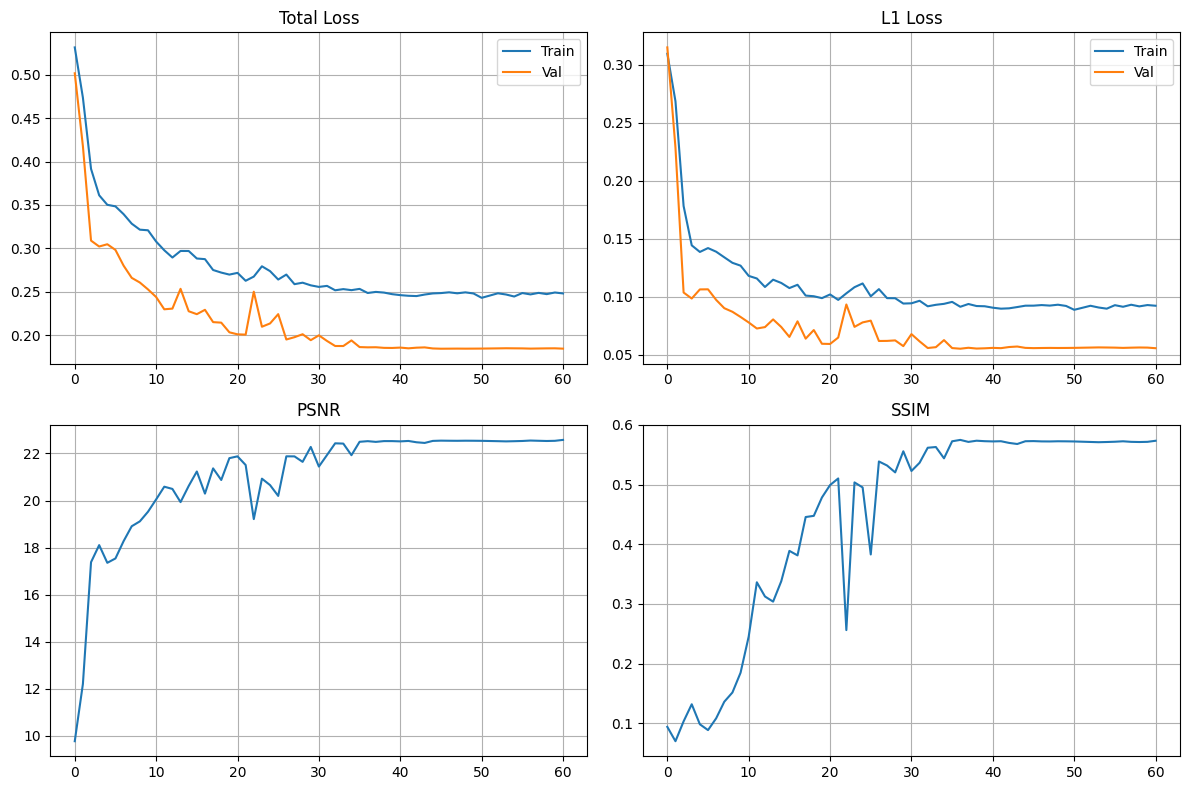

In [20]:
# ============================================================================
# CELL 15: PLOT RESULTS
# ============================================================================

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

axes[0, 0].plot([h['total'] for h in train_history], label='Train')
axes[0, 0].plot([h['total'] for h in val_history], label='Val')
axes[0, 0].set_title('Total Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

axes[0, 1].plot([h['l1'] for h in train_history], label='Train')
axes[0, 1].plot([h['l1'] for h in val_history], label='Val')
axes[0, 1].set_title('L1 Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

axes[1, 0].plot([h['psnr'] for h in val_history])
axes[1, 0].set_title('PSNR')
axes[1, 0].grid(True)

axes[1, 1].plot([h['ssim_metric'] for h in val_history])
axes[1, 1].set_title('SSIM')
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150)
plt.show()

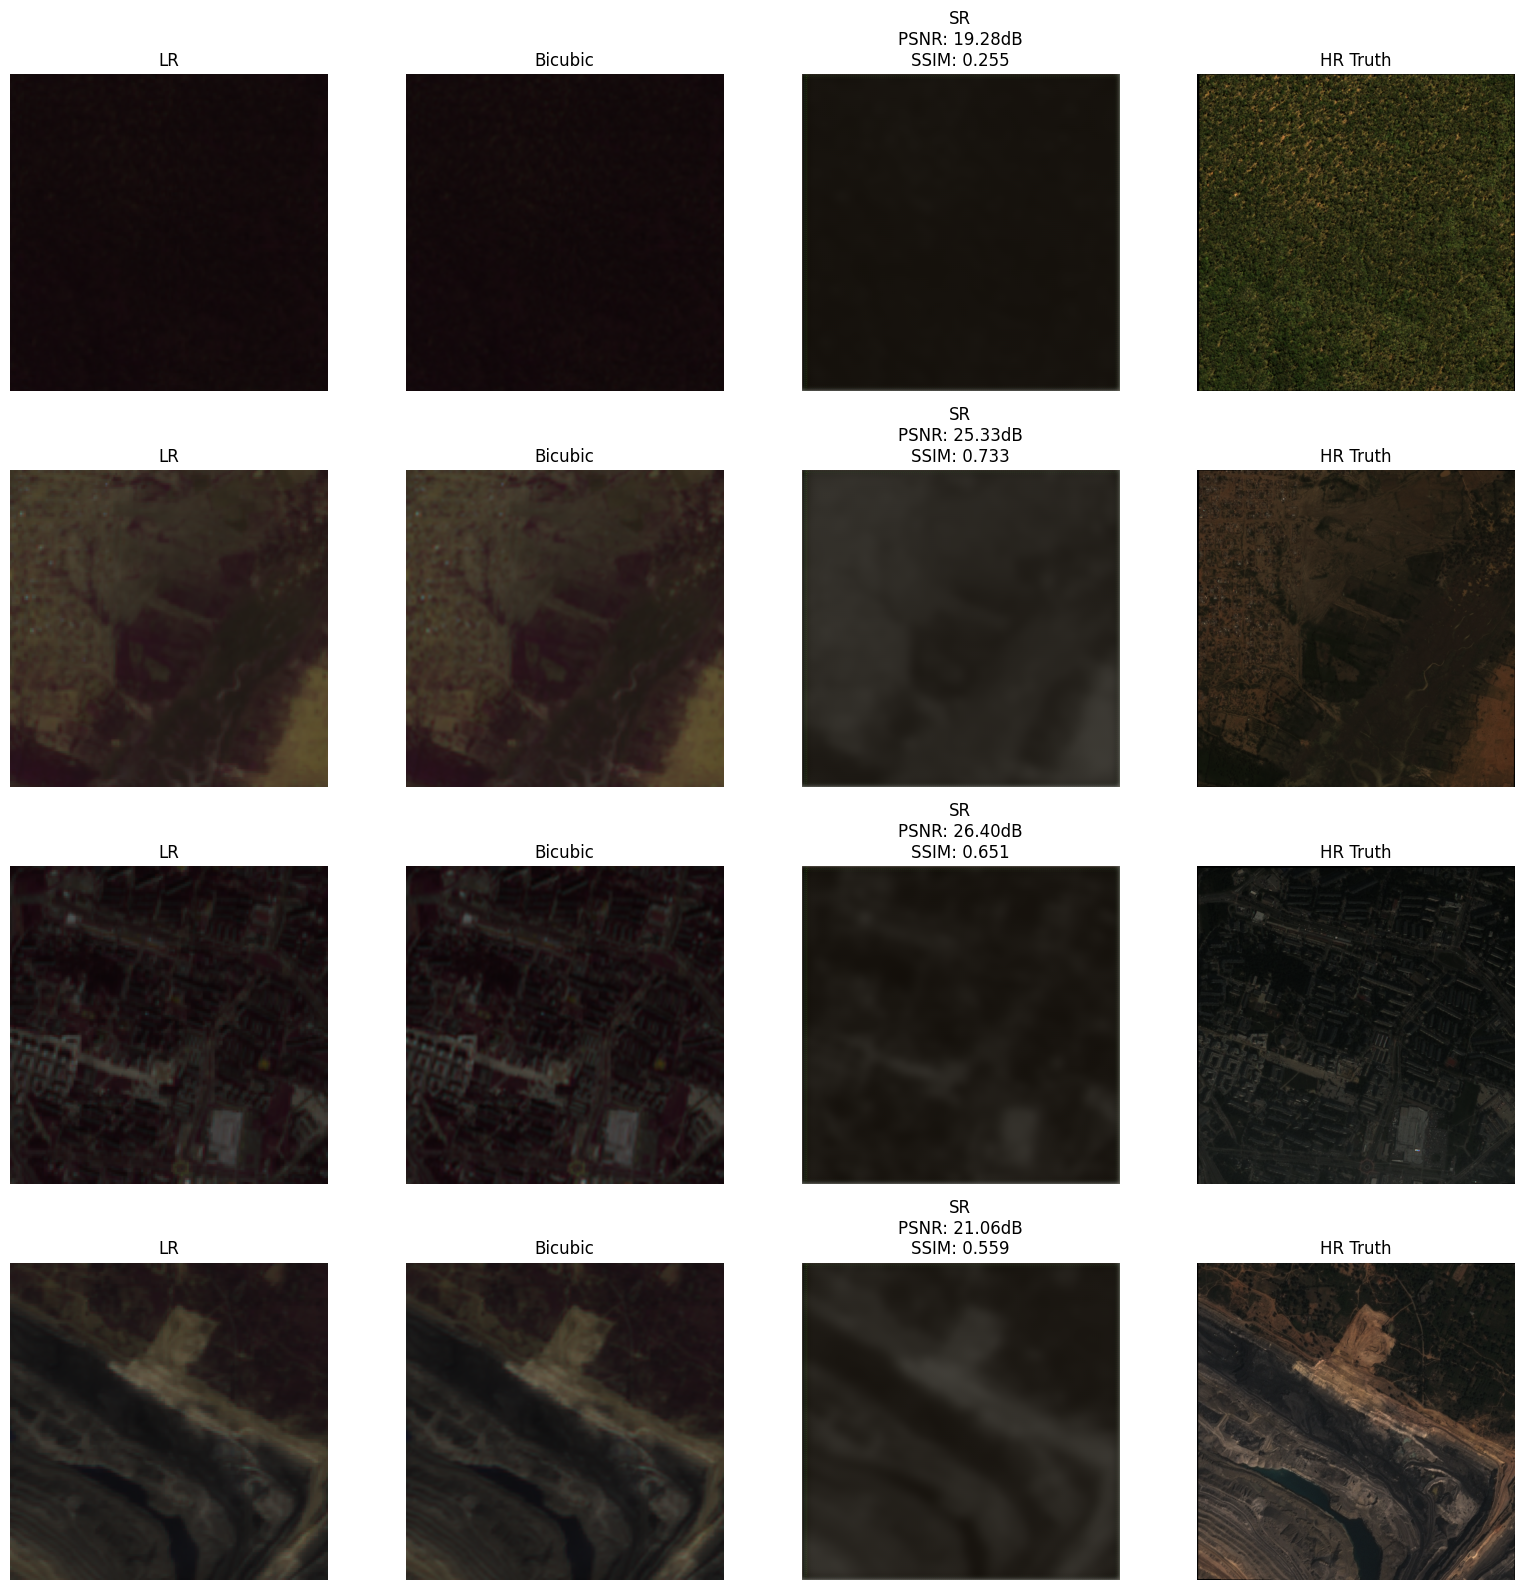

✅ Done!


In [22]:
# ============================================================================
# CELL 16: VISUALIZE RESULTS
# ============================================================================

# ============================================================================

# ============================================================================

ckpt = torch.load(
    'checkpoints/best_model.pth',
    map_location='cpu',
    weights_only=False   
)

model.load_state_dict(ckpt['model_state_dict'])
model.eval()



@torch.no_grad()
def visualize_results(model, dataloader, num_samples=8):
    model.eval()
    samples = []
    for i, batch in enumerate(dataloader):
        if i >= num_samples:
            break
        samples.append(batch)
    
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for i, batch in enumerate(samples):
        inputs = batch['input'].cuda()
        targets = batch['target'].cuda()
        outputs = model(inputs)
        
        lr = inputs[0, :3].cpu().numpy().transpose(1, 2, 0)
        sr = outputs[0].cpu().numpy().transpose(1, 2, 0)
        hr = targets[0].cpu().numpy().transpose(1, 2, 0)
        
        lr = np.clip(lr, 0, 1)
        sr = np.clip(sr, 0, 1)
        hr = np.clip(hr, 0, 1)
        
        lr_bicubic = cv2.resize(lr, (sr.shape[1], sr.shape[0]), interpolation=cv2.INTER_CUBIC)
        psnr = peak_signal_noise_ratio(hr, sr, data_range=1.0)
        ssim_val = structural_similarity(hr, sr, data_range=1.0, channel_axis=2)
        
        axes[i, 0].imshow(lr)
        axes[i, 0].set_title('LR')
        axes[i, 0].axis('off')
        
        axes[i, 1].imshow(lr_bicubic)
        axes[i, 1].set_title('Bicubic')
        axes[i, 1].axis('off')
        
        axes[i, 2].imshow(sr)
        axes[i, 2].set_title(f'SR\nPSNR: {psnr:.2f}dB\nSSIM: {ssim_val:.3f}')
        axes[i, 2].axis('off')
        
        axes[i, 3].imshow(hr)
        axes[i, 3].set_title('HR Truth')
        axes[i, 3].axis('off')
    
    plt.tight_layout()
    plt.savefig('results.png', dpi=150)
    plt.show()

visualize_results(model, dataloaders['val'], num_samples=4)
print("✅ Done!")

In [23]:

# ============================================================================
# DEBUG NORMALIZATION (ONE BATCH)
# ============================================================================

model.eval()
device = next(model.parameters()).device

batch = next(iter(dataloaders['train']))
inputs = batch['input'].to(device)
targets = batch['target'].to(device)

with torch.no_grad():
    outputs = model(inputs)

print("INPUT  min/max :", inputs.min().item(), inputs.max().item())
print("TARGET min/max :", targets.min().item(), targets.max().item())
print("OUTPUT min/max :", outputs.min().item(), outputs.max().item())


INPUT  min/max : 0.0 1.2607421875
TARGET min/max : 0.0 0.9921875
OUTPUT min/max : -0.0761522650718689 0.9608875513076782


In [34]:
import random

@torch.no_grad()
def visualize_results_random(model, dataloader, num_samples=8):
    model.eval()
    batches = list(dataloader)
    selected_batches = random.sample(batches, num_samples)

    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    for i, batch in enumerate(selected_batches):
        inputs = batch['input'].cuda()
        targets = batch['target'].cuda()
        outputs = model(inputs)

        lr = inputs[0, :3].cpu().numpy().transpose(1, 2, 0)
        sr = outputs[0].cpu().numpy().transpose(1, 2, 0)
        hr = targets[0].cpu().numpy().transpose(1, 2, 0)

        lr = np.clip(lr, 0, 1)
        sr = np.clip(sr, 0, 1)
        hr = np.clip(hr, 0, 1)

        lr_bicubic = cv2.resize(lr, (sr.shape[1], sr.shape[0]), interpolation=cv2.INTER_CUBIC)

        psnr = peak_signal_noise_ratio(hr, sr, data_range=1.0)
        ssim_val = structural_similarity(hr, sr, data_range=1.0, channel_axis=2)

        axes[i, 0].imshow(lr)
        axes[i, 0].set_title('LR')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(lr_bicubic)
        axes[i, 1].set_title('Bicubic')
        axes[i, 1].axis('off')

        axes[i, 2].imshow(sr)
        axes[i, 2].set_title(f'SR\nPSNR: {psnr:.2f}dB\nSSIM: {ssim_val:.3f}')
        axes[i, 2].axis('off')

        axes[i, 3].imshow(hr)
        axes[i, 3].set_title('HR Truth')
        axes[i, 3].axis('off')

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0022495613..1.2231629].


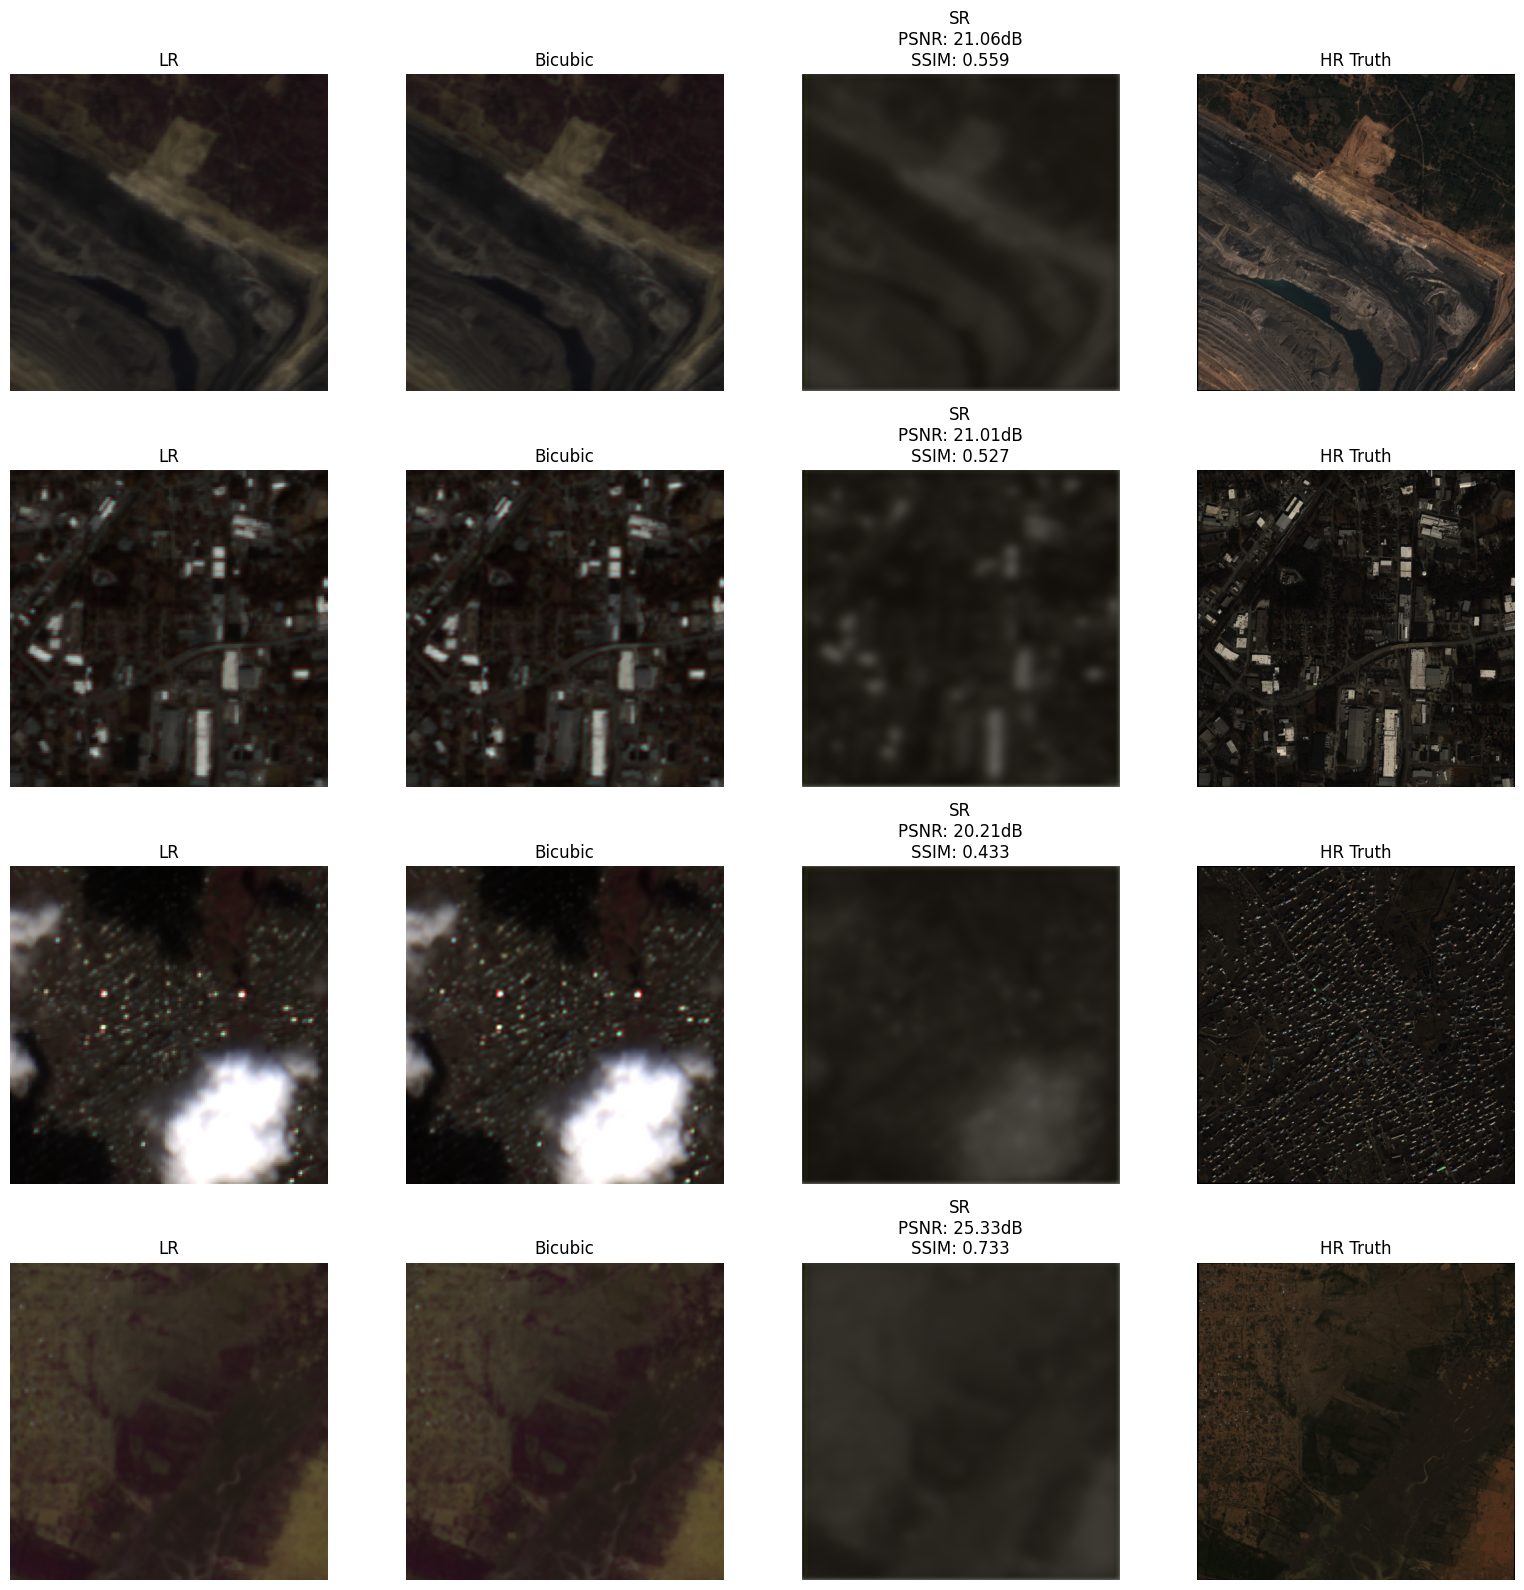

In [37]:
visualize_results_random(model, dataloaders['val'], num_samples=4)
